[View in Colaboratory](https://colab.research.google.com/github/buddharajuramaraju/ImageClassification-DL-Project/blob/master/ImageClassification.ipynb)

**Image Classification Project**
In this project, you'll classify images from the CIFAR-10 dataset

## **Step:1** Downloading data from source

In [0]:
from urllib.request import urlretrieve
from os.path import isfile,isdir
from tqdm import tqdm
import tarfile

    
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import random


In [0]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [0]:
class DLProgress(tqdm):
  last_block = 0
  
  def hook(self,block_num=1,block_size=1,total_size=None):
    self.total = total_size
    self.update((block_num-self.last_block)*block_size)
    self.last_block=block_num

In [8]:
if not isfile('cifar-10-python.tar.gz'):
  with DLProgress(unit='B',unit_scale=True,miniters=1,desc='CIFAR-10 Dataset') as pbar:
    urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz',pbar.hook)
                
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()
  

CIFAR-10 Dataset:  38%|███▊      | 64.4M/170M [00:09<00:13, 7.85MB/s]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
CIFAR-10 Dataset: 171MB [00:27, 6.31MB/s]                           


## **Step:2 Data Visualization**

In [0]:
#function to unpickle images & label_names
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
#get label names from batches.meta file
label_names = unpickle("{}/batches.meta".format(cifar10_dataset_folder_path))
label_name_array=label_names[b'label_names']


In [0]:
#get images and label index from batch files
batch_num = 5 ## values 1 to 5 only
data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))

data = data_label[b'data']
imgs=np.asanyarray(data).astype("uint8")




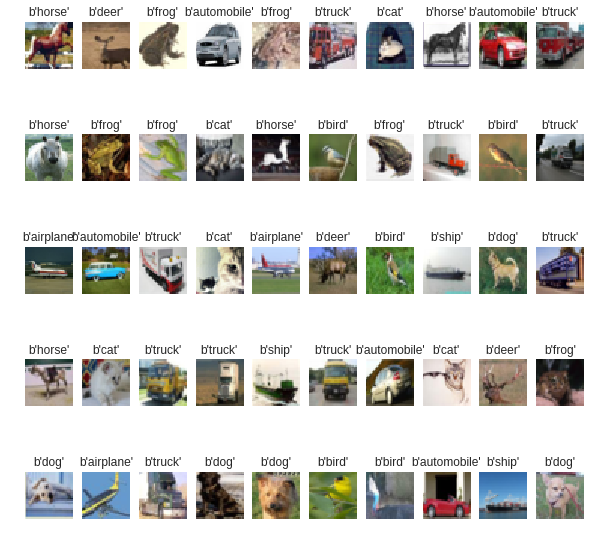

In [30]:
columns = 10
rows = 5
fig=plt.figure(figsize=(10, 10))

for i in range(1, columns*rows +1):
    num = random.randint(0,10000)
    one_img=imgs[num,:]
    img=one_img.reshape(3,32,32).transpose([1, 2, 0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    fig.gca().grid(False)
    plt.title(label_name_array[int(data_label[b'labels'][num])])

## Step:3 Data Preprocessing & Saving

In [0]:
## Function to normalize image data
## This is to convert RGB image to gray scale image of range 0 to 1
def normalize(x):
  return x/255  ## min value is 0 & max value is 255 for RGB


In [0]:
## Function for one-hot encoding 
def one_hot_encoding(x):
  return np.asarray(pd.get_dummies(x))

In [0]:
## Function to load batch from data set
def load_cifar10_batch(cifar10_dataset_folder_path,batch_num):
  data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

## Function to load test data from data set
def load_cifar10_test(cifar10_dataset_folder_path):
  data_label = unpickle("{}/test_batch".format(cifar10_dataset_folder_path))
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

In [0]:
## Function to normalize features and perform one_hot_encoding on labels
def _preprocess_and_save(normalize,one_hot_encoding,features,labels,filename):
  features = normalize(features)
  labels = one_hot_encoding(labels)
  pickle.dump((features,labels),open(filename,'wb'))

In [0]:
## Function to preprocess,split and save Traing, Validation & Test Data
def preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding):
  
  num_batches = 5
  valid_features = []
  valid_labels = []
  
  for i in range (1,num_batches+1):
    
    # Load Data from batches
    features,labels = load_cifar10_batch(cifar10_dataset_folder_path,i)
    valid_count = int(len(features*0.1))
    
    #To Save Traing Data
    _preprocess_and_save(normalize,one_hot_encoding,features[:-valid_count],labels[:-valid_count],"preprocess_batch_{}.p".format(i)) 
    
    # Validation Data from batch
    valid_features.extend(features[-valid_count:])
    valid_labels.extend(labels[-valid_count:])
  
  # To Save Validation Data
  _preprocess_and_save(normalize,one_hot_encoding,np.asarray(valid_features),np.asarray(valid_labels),"preprocess_validation.p".format(i))
  
  
  # To Save Test Data 
  
  features_test,labels_test = load_cifar10_test(cifar10_dataset_folder_path)
  _preprocess_and_save(normalize,one_hot_encoding,features_test,labels_test,"preprocess_test.p".format(i))
  

  

In [0]:
## Preprocess and save Train, Validation & Test Data
preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding)

In [37]:
!ls

cifar-10-batches-py	preprocess_batch_2.p  preprocess_test.p
cifar-10-python.tar.gz	preprocess_batch_3.p  preprocess_validation.p
datalab			preprocess_batch_4.p
preprocess_batch_1.p	preprocess_batch_5.p
